In [1]:
import os
from tqdm import tnrange, tqdm_notebook, tqdm
import torch
import torch.nn.functional as F
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from torchvision.utils import save_image, make_grid
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tensorboardX import SummaryWriter

In [2]:
# os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [3]:
if not os.path.exists('./cnn_dcgan_img'): os.mkdir('./cnn_dcgan_img')

In [4]:
from matplotlib import rcParams
rcParams['figure.figsize'] = (12, 8)

%matplotlib inline

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
device_ids = [0, 1]

In [7]:
batch_size = 128
num_epochs = 100

z_dimension = 100

In [8]:
img_transform = transforms.Compose([
    transforms.Resize(64),
    transforms.ToTensor(),
    transforms.Normalize((.5, .5, .5), (.5, .5, .5))
])

dataset = datasets.MNIST('./datas/mnist/', transform=img_transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

In [9]:
def normal_init(m, mean, std):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        m.weight.data.normal_(mean, std)
        m.bias.data.zero_()

In [10]:
class Discriminator(nn.Module):
    def __init__(self, d=128):
        super(Discriminator, self).__init__()
        
        self.conv1 = nn.Conv2d(1, d, 4, 2, 1)
        self.conv2 = nn.Conv2d(d, d*2, 4, 2, 1)
        self.conv2_bn = nn.BatchNorm2d(d*2)
        self.conv3 = nn.Conv2d(d*2, d*4, 4, 2, 1)
        self.conv3_bn = nn.BatchNorm2d(d*4)
        self.conv4 = nn.Conv2d(d*4, d*8, 4, 2, 1)
        self.conv4_bn = nn.BatchNorm2d(d*8)
        self.conv5 = nn.Conv2d(d*8, 1, 4, 1, 0)
        
    
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)
            
    def forward(self, x): # b 1 28 28
        outs = F.leaky_relu(self.conv1(x), 0.2)
        outs = F.leaky_relu(self.conv2_bn(self.conv2(outs)), 0.2)
        outs = F.leaky_relu(self.conv3_bn(self.conv3(outs)), 0.2)
        outs = F.leaky_relu(self.conv4_bn(self.conv4(outs)), 0.2)
        outs = F.sigmoid(self.conv5(outs))

        return outs

In [11]:
class Generator(nn.Module):
    def __init__(self, d=128):
        super(Generator, self).__init__()
        
        self.deconv1 = nn.ConvTranspose2d(100, d*8, 4, 1, 0) # b d*8 
        self.deconv1_bn = nn.BatchNorm2d(d*8)
        self.deconv2 = nn.ConvTranspose2d(d*8, d*4, 4, 2, 1)
        self.deconv2_bn = nn.BatchNorm2d(d*4)
        self.deconv3 = nn.ConvTranspose2d(d*4, d*2, 4, 2, 1)
        self.deconv3_bn = nn.BatchNorm2d(d*2)
        self.deconv4 = nn.ConvTranspose2d(d*2, d, 4, 2, 1)
        self.deconv4_bn = nn.BatchNorm2d(d)
        self.deconv5 = nn.ConvTranspose2d(d, 1, 4, 2, 1)
        
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)
            
    def forward(self, x): # b 100 28 28
        outs = F.relu(self.deconv1_bn(self.deconv1(x)))
        outs = F.relu(self.deconv2_bn(self.deconv2(outs)))
        outs = F.relu(self.deconv3_bn(self.deconv3(outs)))
        outs = F.relu(self.deconv4_bn(self.deconv4(outs)))
        outs = F.tanh(self.deconv5(outs))

        return outs

In [12]:
d = Discriminator(128).to(device)
g = Generator(128).to(device)

d.weight_init(.0, 0.02)
g.weight_init(.0, 0.02)

d = nn.DataParallel(d, device_ids=device_ids).to(device)
g = nn.DataParallel(g, device_ids=device_ids).to(device)

criterion = nn.BCELoss()

d_optimezer = optim.Adam(d.parameters(), lr=2e-4, betas=(0.5, 0.999))
g_optimezer = optim.Adam(g.parameters(), lr=2e-4, betas=(0.5, 0.999))

/usr/local/lib/python2.7/dist-packages/torch/nn/parallel/data_parallel.py:24: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 0 which
    has less than 75% of the memory or cores of GPU 1. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


In [13]:
writer = SummaryWriter('./log/cnn_dcgan')

In [ ]:
total_count = len(dataloader)
for epoch in tqdm_notebook(xrange(num_epochs)):
    _step = epoch * total_count
    
    d_loss_total = .0
    g_loss_total = .0
    for i, (img, _) in enumerate(dataloader):
        
        mini_batch = img.size(0)
        real_img = img.cuda()
        real_labels = torch.ones(mini_batch, 1, 1, 1).cuda()
        fake_labels = torch.zeros(mini_batch, 1, 1, 1).cuda()
        
        real_out = d(real_img)
        d_loss_real = criterion(real_out, real_labels)
        real_scores = real_out
        
        z = torch.randn(img.size(0), z_dimension).view(-1, 100, 1, 1).cuda()
        fake_img = g(z)
        fake_out = d(fake_img)
        d_loss_fake = criterion(fake_out, fake_labels)
        fake_scores = fake_out
        
        d_loss = d_loss_real + d_loss_fake
        d_optimezer.zero_grad()
        d_loss.backward()
        d_optimezer.step()
        
        z = torch.randn(img.size(0), z_dimension).view(-1, 100, 1, 1).cuda()
        fake_img = g(z)
        fake_out = d(fake_img)
        g_loss = criterion(fake_out, real_labels)
        
        g_optimezer.zero_grad()
        g_loss.backward()
        g_optimezer.step()
        
        d_loss_total += d_loss.item() * img.size(0)
        g_loss_total += g_loss.item() * img.size(0)
        
        step = _step + i + 1
        
        if (i + 1) % 100 == 0:
            writer.add_scalar('Discriminator Real Loss', d_loss_real.item(), step)
            writer.add_scalar('Discriminator Fake Loss', d_loss_fake.item(), step)
            writer.add_scalar('Discriminator Loss', d_loss.item(), step)
            writer.add_scalar('Generator Loss', g_loss.item(), step)
        
        
        if (i + 1) % 200 == 0:
            tqdm.write('Epoch [{}/{}], Step: {:6d}, d_loss: {:.6f}, g_loss: {:.6f}, real_scores: {:.6f}' \
', fake_scores: {:.6f}'.format(epoch+1, num_epochs, (i+1) * batch_size, d_loss, g_loss, real_scores.mean(), fake_scores.mean()))
    
    
    setp = (epoch + 1) * total_count
    _d_loss_total = d_loss_total / (total_count * (epoch + 1))
    _g_loss_total = g_loss_total / (total_count * (epoch + 1))
    
    writer.add_scalar('Discriminator Total Loss', _d_loss_total, step)
    writer.add_scalar('Generator Total Loss', _g_loss_total, step)
    
    tqdm.write("Finish Epoch [{}/{}], D Loss: {:.6f}, G Loss: {:.6f}".format(epoch+1, 
                                                                             num_epochs, 
                                                                             _d_loss_total,
                                                                             _g_loss_total, ))
    
    writer.add_image('Generator Image', make_grid(fake_img.view(-1, 1, 64, 64).cpu().data, normalize=True, scale_each=True), step)
    
    if epoch == 0:
        real_images = real_img.view(-1, 1, 64, 64).cpu().data
        save_image(real_images, './cnn_dcgan_img/real_images.png')
    
    
    
    fake_images = fake_img.view(-1, 1, 64, 64).cpu().data
    save_image(fake_images, './cnn_dcgan_img/fake_images-{}.png'.format(epoch+1))

HBox(children=(IntProgress(value=0), HTML(value=u'')))

Epoch [1/100], Step:  25600, d_loss: 0.000090, g_loss: 27.630657, real_scores: 0.999910, fake_scores: 0.000000
Epoch [1/100], Step:  51200, d_loss: 0.235794, g_loss: 3.080480, real_scores: 0.881561, fake_scores: 0.093847
Finish Epoch [1/100], D Loss: 54.357024, G Loss: 1907.984655
Epoch [2/100], Step:  25600, d_loss: 0.880478, g_loss: 0.838485, real_scores: 0.550610, fake_scores: 0.164468
Epoch [2/100], Step:  51200, d_loss: 0.529139, g_loss: 2.508429, real_scores: 0.811086, fake_scores: 0.242364
Finish Epoch [2/100], D Loss: 45.530316, G Loss: 145.858855
Epoch [3/100], Step:  25600, d_loss: 0.634092, g_loss: 1.238972, real_scores: 0.613096, fake_scores: 0.038738
Epoch [3/100], Step:  51200, d_loss: 0.563286, g_loss: 1.264220, real_scores: 0.674065, fake_scores: 0.102723
Finish Epoch [3/100], D Loss: 28.892624, G Loss: 112.096306
Epoch [4/100], Step:  25600, d_loss: 0.211732, g_loss: 4.091733, real_scores: 0.902209, fake_scores: 0.091500
Epoch [4/100], Step:  51200, d_loss: 0.347864, g

Epoch [30/100], Step:  51200, d_loss: 0.013141, g_loss: 6.445673, real_scores: 0.998958, fake_scores: 0.011889
Finish Epoch [30/100], D Loss: 0.137315, G Loss: 23.840983
Epoch [31/100], Step:  25600, d_loss: 0.319310, g_loss: 3.297762, real_scores: 0.925557, fake_scores: 0.189978
Epoch [31/100], Step:  51200, d_loss: 0.269485, g_loss: 7.028339, real_scores: 0.993620, fake_scores: 0.213109
Finish Epoch [31/100], D Loss: 1.829819, G Loss: 17.866706
Epoch [32/100], Step:  25600, d_loss: 0.207546, g_loss: 7.670907, real_scores: 0.997803, fake_scores: 0.172751
Epoch [32/100], Step:  51200, d_loss: 0.847670, g_loss: 2.020749, real_scores: 0.700767, fake_scores: 0.288667
Finish Epoch [32/100], D Loss: 1.859366, G Loss: 14.646003
Epoch [33/100], Step:  25600, d_loss: 0.077761, g_loss: 5.304980, real_scores: 0.992387, fake_scores: 0.065423
Epoch [33/100], Step:  51200, d_loss: 0.016864, g_loss: 5.763041, real_scores: 0.991904, fake_scores: 0.008623
Finish Epoch [33/100], D Loss: 0.990279, G Los

In [14]:
writer.close()

In [15]:
torch.save(d.state_dict(), './ser/discriminator.pkl')
torch.save(g.state_dict(), './ser/generator.pkl')

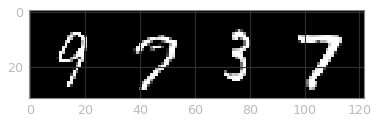

In [16]:
z = torch.randn(4, z_dimension).to(device)
images = g(z)
# save_image(images, 'xx.png')
plt.imshow(Image.fromarray(make_grid(images).mul(255).clamp(0, 255).byte().permute(1, 2, 0).cpu().numpy()))
plt.show()